In [8]:
import pandas as pd
import altair as alt
import networkx as nx
import nx_altair as nxa
from pydracor import *
# temporal imports for seaborn
import matplotlib.pyplot as plt 
import seaborn 

dracor = DraCor()

In [9]:
plays = dracor.play_id_to_play_title()
available_german_plays = filtered_grades = dict(filter(lambda play: 'ger0' in play[0], plays.items()))
#available_german_plays

In [86]:

# play = Play('ger000088')
#play = Play('ger000597')
#play = Play('ger000378')
play = Play('ger000311') # Maria Stuart
# play = Play('ger000201') # Faust zwei, 189 Characters ie stress test 
graphml = play.relations_graphml()
# networkX doesn't support mix of directed+undirected Graphs & nx_altair's arrows look broken
# workaround: make graph undirected
graphml = graphml.replace('directed="true"', 'directed="false"')

G = nx.parse_graphml(graphml)
G.nodes.data()
G.edges.data()

# Load corpera Metadata and select the metadata for play
gerCorp = Corpus('ger')
gerMetadata = pd.DataFrame(gerCorp.metadata())

# load play metadata ie the single line in da pd frame
playid = play.summary().get('id')
playMetadata = gerMetadata[gerMetadata["id"] == playid].reset_index()


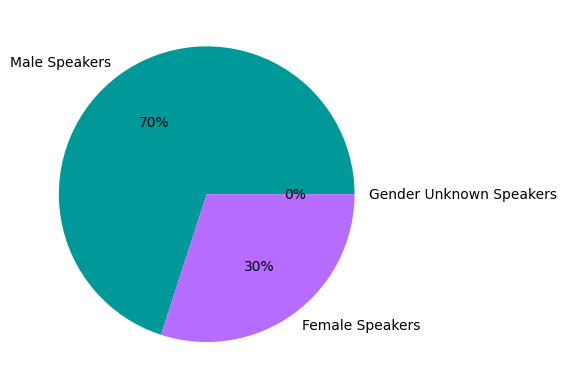

alt.Chart(...)

In [87]:
# data for num speaker pie char
speakers=playMetadata[['num_of_speakers_male', 'num_of_speakers_female', 'num_of_speakers_unknown']]
#print(speakers)
palette_color = seaborn.color_palette('bright')
labelSpeakerList = ['Male Speakers', 'Female Speakers', 'Gender Unknown Speakers'] 
# plotting data on chart male color #009999', Female color '#b66dff'unkown color'#db6d00' alternative palletwith different hue:#004949 #b66dff #ffdf4d  https://lospec.com/palette-list/colorblind-16
plt.pie(x=speakers.loc[0,:].values.tolist(),
        labels=labelSpeakerList, 
        colors=['#009999','#b66dff','#db6d00'], 
        autopct='%.0f%%') 
  
# displaying seaborn chart 
plt.show()

# altair chart
speakersAlt = pd.DataFrame({'Genders':labelSpeakerList, 'Number of Speakers':speakers.loc[0,:].values.tolist()})

numeberSpeakerGenderPieAlt= alt.Chart(speakersAlt, title='Speaker/Character distribution in $Play by gender' ).mark_arc().encode(
    theta='Number of Speakers',
    color='Genders:N'
)
numeberSpeakerGenderPieAlt #todo's add marks ie percentages

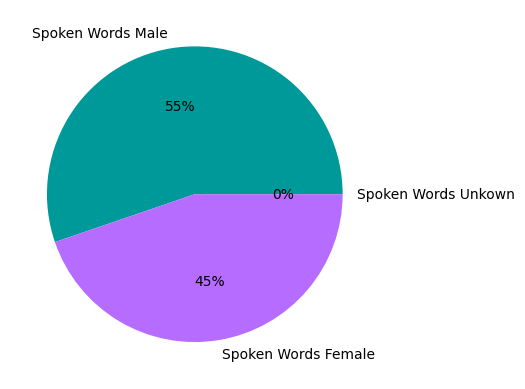

alt.Chart(...)

In [88]:
# Pie Chart Spoken words by gender
# 1. aggregate num. of spoken words by gender
coOGraphML = play.graphml()
coOGrapNX = nx.parse_graphml(coOGraphML,force_multigraph=True)
femaleWords = 0
maleWords = 0
unknownWords = 0
for nodeitterator in coOGrapNX.nodes: 
    node = coOGrapNX.nodes[nodeitterator]
    if node['Gender'] == 'FEMALE':
       femaleWords += node['Number of spoken words']
    elif node['Gender'] == 'MALE':
       maleWords += node['Number of spoken words']
    elif node['Gender'] == 'UNKNOWN':
       unknownWords += node['Number of spoken words']

spokenwordList = [maleWords,femaleWords,unknownWords] # odering the same way the gender of the speaker are in the metadata
# plot seaborn pie chart
plt.pie( x= spokenwordList, 
        labels= ['Spoken Words Male','Spoken Words Female','Spoken Words Unkown'], 
        colors=['#009999','#b66dff','#db6d00'], 
        autopct='%.0f%%') 
plt.show() 

# altair pie chart 
spokenwordListAlt = pd.DataFrame({'Genders':['Spoken Words Male','Spoken Words Female','Spoken Words Unkown'], 'Words':spokenwordList})

spokenWordsGenderPieCharAlt=alt.Chart(spokenwordListAlt,title='Spoken words distributution in $PLAY by gender').mark_arc().encode(
    theta='Words',
    color='Genders:N'
)
spokenWordsGenderPieCharAlt #todo's add marks ie percentages,


In [162]:
#################### Network Chart ####################

# define the graph layout
layout = nx.shell_layout(G)

# draw base graph with nx_altair
base = nxa.draw_networkx(
    G,
    pos=layout,
    node_tooltip=['label', 'Gender'],
    node_color='lightgray',
    edge_color='Relation',
    width=2
)
# get the edge layer
edges = base.layer[0]
# get the node layer
nodes = base.layer[1]

# define relationship filter
relation = pd.DataFrame({'Relation': ['parent_of', 'lover_of', 'related_with', 'associated_with', 'siblings', 'spouses', 'friends']})
relation_selection = alt.selection_point(fields=['Relation'], toggle="true")
relation_color = alt.condition(relation_selection, alt.Color('Relation:N', legend=None), alt.value('lightgray'))
relation_filter = alt.Chart(relation, title=alt.TitleParams('Filter Relationship', anchor='start')).mark_rect().encode(
    y=alt.Y('Relation', title=''), 
    color=relation_color
).add_params(relation_selection)

# add relationship filter
edges = edges.encode(color=relation_color).transform_filter(relation_selection)

# define gender filter
gender = pd.DataFrame({'Gender': ['FEMALE', 'MALE', 'UNKNOWN']})
gender_selection = alt.selection_point(fields=['Gender'], toggle="true")
gender_color = alt.condition(gender_selection, alt.Color('Gender:N', legend=None), alt.value('lightgray'))
gender_shape = alt.Shape('Gender:N', legend=None)
gender_filter = alt.Chart(
    gender, 
    title=alt.TitleParams('Filter Gender', anchor='start')
).mark_point(size=250).encode(
    y=alt.Y('Gender', title=''), 
    color=gender_color,
    fill=gender_color,
    shape=gender_shape
).add_params(gender_selection)

# encode gender as node shape+color and add gender filter
nodes = nodes.encode(
    color=gender_color,
    fill=gender_color,
    shape=gender_shape
).add_params(gender_selection)

# print the Chart layers
#layered_chart = ((relation_filter & gender_filter) | (edges + nodes) | (spokenWordsGenderPieCharAlt & numeberSpeakerGenderPieAlt))
network_chart = (edges + nodes).properties(
    width=400,
    height=400
)
network_chart_with_filters = ((gender_filter & relation_filter) | network_chart)

#################### Pie Charts ####################

numeberSpeakerGenderPieAlt= alt.Chart(speakersAlt, title='Speaker/Character distribution in $Play by gender' ).mark_arc().encode(
    theta='Number of Speakers',
    color=gender_color
).properties(
    width=200,
    height=200
)

#################### Concatenated Chart ####################

layered_chart = alt.hconcat(network_chart_with_filters, numeberSpeakerGenderPieAlt).resolve_scale(color='independent')
layered_chart.configure_view(
    strokeWidth=0 # remove border
).configure_axis(
    domainOpacity=0 # remove axis
)

alt.HConcatChart(...)